In [29]:
import sys
print(sys.stdout.encoding)

UTF-8


In [30]:
import matplotlib.pyplot as plt

# 윈도우
plt.rc('font', family='Malgun Gothic') 
plt.rc('axes', unicode_minus=False)

In [ ]:
import os
import cv2
import json
import matplotlib.pyplot as plt
import pandas as pd

origin_dir = '..'

# 경로 설정
img_dir = os.path.join(origin_dir, 'data', 'train_images')       # 이미지가 있는 폴더
anno_dir = os.path.join(origin_dir, 'data', 'train_annotations') # 어노테이션 폴더 (json)

# 이미지 파일 목록
img_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]
print('이미지 개수:', len(img_files))
print('샘플 5개:', img_files[:5])

# 어노테이션 파일 목록 (json 여러 개라면 os.walk로 탐색)
json_files = []
for root, dirs, files in os.walk(anno_dir):
    for f in files:
        if f.endswith('.json'):
            json_files.append(os.path.join(root, f))
print('어노테이션 파일 개수:', len(json_files))
print('샘플 3개:', json_files[:3])

# json 하나 열어서 구조 확인
with open(json_files[0], 'r', encoding='utf-8') as f:
    data = json.load(f)

print('keys:', data.keys())
print('이미지 수:', len(data['images']))
print('어노테이션 수:', len(data['annotations']))
print('카테고리 수:', len(data['categories']))

# 카테고리 이름(unique class) 확인
categories = pd.DataFrame(data['categories'])
print('유니크 클래스 개수:', categories.shape[0])
print('클래스 이름 예시:', categories.head())

이미지 개수: 1489
샘플 5개: ['K-001900-010224-016551-031705_0_2_0_2_70_000_200.png', 'K-001900-010224-016551-031705_0_2_0_2_75_000_200.png', 'K-001900-010224-016551-031705_0_2_0_2_90_000_200.png', 'K-001900-010224-016551-033009_0_2_0_2_70_000_200.png', 'K-001900-010224-016551-033009_0_2_0_2_75_000_200.png']
어노테이션 파일 개수: 4526
샘플 3개: ['..\\data\\train_annotations\\K-001900-010224-016551-031705_json\\K-001900\\K-001900-010224-016551-031705_0_2_0_2_70_000_200.json', '..\\data\\train_annotations\\K-001900-010224-016551-031705_json\\K-001900\\K-001900-010224-016551-031705_0_2_0_2_75_000_200.json', '..\\data\\train_annotations\\K-001900-010224-016551-031705_json\\K-001900\\K-001900-010224-016551-031705_0_2_0_2_90_000_200.json']
keys: dict_keys(['images', 'type', 'annotations', 'categories'])
이미지 수: 1
어노테이션 수: 1
카테고리 수: 1
유니크 클래스 개수: 1
클래스 이름 예시:   supercategory    id        name
0          pill  1899  보령부스파정 5mg


### 클래스 개수 및 bbox 평균

In [ ]:
from collections import Counter

all_classes = []
all_boxes = []

for jf in json_files[:1000]:
    with open(jf, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # 카테고리 정보
    for cat in data['categories']:
        all_classes.append(cat['name'])
    
    # 바운딩 박스 정보
    for ann in data['annotations']:
        if 'bbox' in ann and len(ann['bbox']) == 4:
            all_boxes.append(ann['bbox'])

# 클래스 분포
cls_counter = Counter(all_classes)
print('상위 10개 클래스:', cls_counter.most_common(10))

# 바운딩 박스 크기 분포
import numpy as np
widths = [b[2] for b in all_boxes]
heights = [b[3] for b in all_boxes]
print('bbox 평균 크기:', np.mean(widths), np.mean(heights))


상위 10개 클래스: [('보령부스파정 5mg', 180), ('가바토파정 100mg', 89), ('동아가바펜틴정 800mg', 87), ('뮤테란캡슐 100mg', 77), ('알드린정', 54), ('비모보정 500/20mg', 32), ('스토가정 10mg', 32), ('낙소졸정 500/20mg', 31), ('신바로정', 31), ('레일라정', 31)]
bbox 평균 크기: 253.45 313.035


Unique Size 확인

In [ ]:
from PIL import Image
import os
from collections import Counter

sizes = []
for f in os.listdir(img_dir):
    if f.endswith('.png'):
        path = os.path.join(img_dir, f)
        with Image.open(path) as img:
            sizes.append(img.size)  # (width, height)

# 유니크한 사이즈 종류
unique_sizes = Counter(sizes)

print('총 이미지 개수:', len(sizes))
print('유니크 사이즈 개수:', len(unique_sizes))
print('상위 10개 사이즈:', unique_sizes.most_common(10))

총 이미지 개수: 1489
유니크 사이즈 개수: 1
상위 10개 사이즈: [((976, 1280), 1489)]


### bbox 시각화

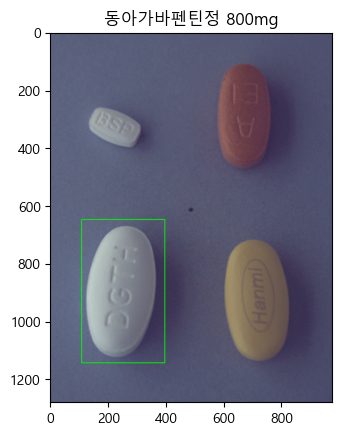

In [ ]:
import random
import cv2

sample_json = random.choice(json_files)
with open(sample_json, 'r', encoding='utf-8') as f:
    data = json.load(f)

img_info = data['images'][0]
img_path = os.path.join(img_dir, img_info['file_name'])
img = cv2.imread(img_path)

for ann in data['annotations']:
    x, y, w, h = ann['bbox']
    x1, y1, x2, y2 = int(x), int(y), int(x+w), int(y+h)
    cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(data['categories'][0]['name'])
plt.show()


### 클래스 분포 확인
편향된 데이터로 생각됨

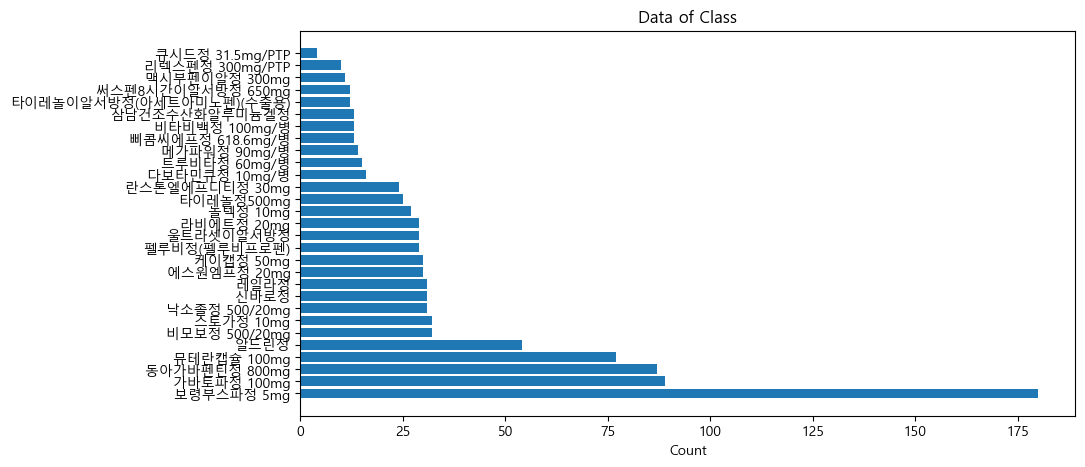

In [ ]:
import matplotlib.pyplot as plt

top_classes = cls_counter.most_common(29)  # 모든 클래스
names, counts = zip(*top_classes)

plt.figure(figsize=(10,5))
plt.barh(names, counts)
plt.xlabel('Count')
plt.title('Data of Class')
plt.show()


### Yolo용 Dataset 구성
label의 txt파일과 train/val을 나눠서 data_yolo 폴더에 따로 저장(고마워 gpt..)

In [36]:
label_root = os.path.join(origin_dir, 'configs/yolo_labels')
os.makedirs(os.path.join(label_root, 'train'), exist_ok=True)
os.makedirs(os.path.join(label_root, 'val'), exist_ok=True)

In [ ]:
import os, json, random, shutil
from collections import defaultdict
from pathlib import Path

img_dir = os.path.join(origin_dir, 'data/train_images')
anno_dir = os.path.join(origin_dir, 'data/train_annotations')

# 새 YOLO용 경로
yolo_root = os.path.join(origin_dir, 'data_yolo')
img_train_dir = os.path.join(yolo_root, 'images/train')
img_val_dir = os.path.join(yolo_root, 'images/val')
lbl_train_dir = os.path.join(yolo_root, 'labels/train')
lbl_val_dir = os.path.join(yolo_root, 'labels/val')

for d in [img_train_dir, img_val_dir, lbl_train_dir, lbl_val_dir]:
    os.makedirs(d, exist_ok=True)

# -----------------------
# 1) 모든 json 모으기
# -----------------------
json_files = []
for root, _, files in os.walk(anno_dir):
    for f in files:
        if f.endswith('.json'):
            json_files.append(os.path.join(root, f))
print('총 JSON 개수:', len(json_files))

# -----------------------
# 2) 전역 class_map (name → id)
# -----------------------
class_map = {}
class_counter = 0
for jf in json_files:
    with open(jf, 'r', encoding='utf-8') as f:
        data = json.load(f)
    for cat in data.get('categories', []):
        name = cat['name']
        if name not in class_map:
            class_map[name] = class_counter
            class_counter += 1
print('클래스 개수:', len(class_map))

# -----------------------
# 3) 이미지별 json 묶기
# -----------------------
img2json = defaultdict(list)
for jf in json_files:
    with open(jf, 'r', encoding='utf-8') as f:
        data = json.load(f)
    img_name = data['images'][0]['file_name']
    img2json[img_name].append(jf)
print('총 이미지 개수:', len(img2json))

# -----------------------
# 4) YOLO txt 변환 함수
# -----------------------
def convert_jsons_to_txt(json_list, save_dir, class_map):
    if not json_list: return None
    with open(json_list[0], 'r', encoding='utf-8') as f:
        first_data = json.load(f)
    img = first_data['images'][0]
    img_w, img_h = img['width'], img['height']
    img_name = img['file_name']
    label_path = os.path.join(save_dir, img_name.replace('.png', '.txt'))

    yolo_lines = []
    for jf in json_list:
        with open(jf, 'r', encoding='utf-8') as f:
            data = json.load(f)
        id2name = {cat['id']: cat['name'] for cat in data['categories']}
        for ann in data['annotations']:
            if 'bbox' not in ann or len(ann['bbox']) != 4:
                continue
            x, y, w, h = ann['bbox']
            x_center = (x + w / 2) / img_w
            y_center = (y + h / 2) / img_h
            w /= img_w
            h /= img_h

            cat_id = ann['category_id']
            if cat_id not in id2name:
                continue
            name = id2name[cat_id]
            if name not in class_map:
                continue
            cls_id = class_map[name]

            yolo_lines.append(f'{cls_id} {x_center} {y_center} {w} {h}')

    if yolo_lines:
        with open(label_path, 'w', encoding='utf-8') as f:
            f.write('\n'.join(yolo_lines) + '\n')
    return img_name

# -----------------------
# 5) Split train/val
# -----------------------
images = list(img2json.keys())
random.shuffle(images)
split_idx = int(len(images) * 0.8)
train_imgs, val_imgs = images[:split_idx], images[split_idx:]

print('Train 이미지:', len(train_imgs))
print('Val 이미지:', len(val_imgs))

# -----------------------
# 6) 변환 및 심볼릭 링크 생성
# -----------------------
def symlink(src, dst):
    try:
        os.symlink(src, dst)   # Unix
    except AttributeError:
        import subprocess
        subprocess.call(['mklink', '/D', dst, src], shell=True)  # Windows

# train set
for img_name in train_imgs:
    img_src = os.path.join(img_dir, img_name)
    img_dst = os.path.join(img_train_dir, img_name)
    if not os.path.exists(img_dst):
        try:
            symlink(img_src, img_dst)
        except:
            shutil.copy(img_src, img_dst)  # fallback
    convert_jsons_to_txt(img2json[img_name], lbl_train_dir, class_map)

# val set
for img_name in val_imgs:
    img_src = os.path.join(img_dir, img_name)
    img_dst = os.path.join(img_val_dir, img_name)
    if not os.path.exists(img_dst):
        try:
            symlink(img_src, img_dst)
        except:
            shutil.copy(img_src, img_dst)  # fallback
    convert_jsons_to_txt(img2json[img_name], lbl_val_dir, class_map)

print('YOLO data_yolo 준비 완료 ✅')
print('data_yolo/images/train:', len(os.listdir(img_train_dir)))
print('data_yolo/labels/train:', len(os.listdir(lbl_train_dir)))


총 JSON 개수: 4526
클래스 개수: 73
총 이미지 개수: 1489
Train 이미지: 1191
Val 이미지: 298
YOLO data_yolo 준비 완료 ✅
data_yolo/images/train: 1191
data_yolo/labels/train: 1191


In [ ]:
import os

class_ids = set()

for split in ['train', 'val']:
    split_dir = os.path.join(label_root, split)
    for f in os.listdir(split_dir):
        if f.endswith('.txt'):
            with open(os.path.join(split_dir, f), 'r', encoding='utf-8') as ftxt:
                for line in ftxt:
                    cls_id = int(line.split()[0])
                    class_ids.add(cls_id)

print('클래스 개수:', len(class_ids))
print('클래스 ID 목록:', sorted(class_ids))


클래스 개수: 73
클래스 ID 목록: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]


### yaml 생성

In [ ]:
import yaml

yaml_path = '../configs/yolo_data.yaml'

data_yaml = {
    'train': '../data_yolo/images/train',
    'val': '../data_yolo/images/val',
    'nc': len(class_map),
    'names': [name for name, _ in sorted(class_map.items(), key=lambda x: x[1])]
}

with open(yaml_path, 'w', encoding='utf-8') as f:
    yaml.dump(data_yaml, f, allow_unicode=True)

print(f'yaml 저장 완료 → {yaml_path}')

yaml 저장 완료 → ../configs/yolo_data.yaml
